# Data Analysis using XGBoost
We are going to use boosted trees. The question is: why don't we use the gradient boosted in Spark?

THe reason is that, in our experience, XGBoost running on a single machine is much faster than Spark running on 10 machines. So we use XGBoost and am showing you how to use it here.

## Importing Required Libraries

In [1]:
%matplotlib inline
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from lib import XGBHelper as xgbh

## Loading Data

The data files were preprocessed on PySpark (10 nodes) cluster. The code for the same can be found [here](Data_Processing_Whales.ipynb). The preprocessed is a numpy array with `4175` rows (for the 10mb file) with following columns (zero-indexed):
* Col 0-9: projections on first 10 eigen vectors
* Col 10: rmse
* Col 11: peak2peak
* Col 12: label (`0 if row.species==u'Gervais' else 1`)

In [2]:
#Use Data/processed_data_150mb.np for a slightly bigger file
data  = np.load("Data/processed_data_15mb.np")
X = data[:, :-1]
y = np.array(data[:, -1], dtype=int)

## Train - Test - Validation

The data is shuffled and divided as follow:
* Training: 70%
* Validation: 15%
* Testing: 15%

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Model Training and Feature Visualization

## Setting Parameters for XG Boost
* Maximum Depth of the Tree = 3 _(maximum depth of each decision trees)_
* Step size shrinkage used in update to prevents overfitting = 0.3 _(how to weigh trees in subsequent iterations)_
* Evaluation Criterion= `Maximize Loglikelihood` _(maximizing cross entropy)_
* Maximum Number of Iterations = 1000 _(total number trees for boosting)_
* Early Stop if score on Validation does not improve for 5 iterations

In [4]:
param = {'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic'}

# total number of cores to use
param['nthread'] = 7 
param['eval_metric'] = 'logloss'

plst = param.items()
evallist = [(dtrain, 'train'), (dtest, 'eval')]

## Training the model

Note: Running XGBoost for 1000 iterations takes about 70-80 minutes to train. Use **verbose_eval=True** to track number of iterations complete.

In [5]:
# bst is model with 100 iterations
num_round = 100
# Use early_stopping_rounds=5 to enable early stopping
bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False)

# bst1000 is model with 1000 iterations
num_round = 1000
# Use early_stopping_rounds=5 to enable early stopping
bst1000 = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False)

## Visualize the Feature Importance

In [6]:
features_map = {'f0' : 'Eigen Projection 1', 'f1' : 'Eigen Projection 2',
                'f2' : 'Eigen Projection 3', 'f3' : 'Eigen Projection 4',
                'f4' : 'Eigen Projection 5', 'f5' : 'Eigen Projection 6',
                'f6' : 'Eigen Projection 7', 'f7' : 'Eigen Projection 8',
                'f8' : 'Eigen Projection 9', 'f9' : 'Eigen Projection 10',
                'f10' : 'RMSE', 'f11' : 'Peak2Peak'}

100 Iterations


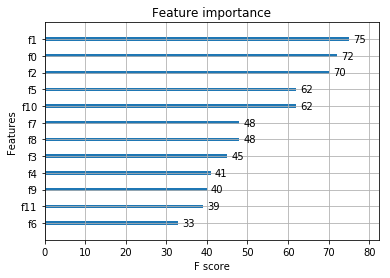

Feature Mapping:
f0 	:  Eigen Projection 1
f1 	:  Eigen Projection 2
f2 	:  Eigen Projection 3
f3 	:  Eigen Projection 4
f4 	:  Eigen Projection 5
f5 	:  Eigen Projection 6
f6 	:  Eigen Projection 7
f7 	:  Eigen Projection 8
f8 	:  Eigen Projection 9
f9 	:  Eigen Projection 10
f10 	:  RMSE
f11 	:  Peak2Peak


In [7]:
print("100 Iterations")
xgbh.visualize_features(bst, features_map)

1000 Iterations


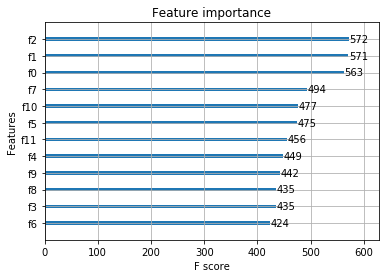

Feature Mapping:
f0 	:  Eigen Projection 1
f1 	:  Eigen Projection 2
f2 	:  Eigen Projection 3
f3 	:  Eigen Projection 4
f4 	:  Eigen Projection 5
f5 	:  Eigen Projection 6
f6 	:  Eigen Projection 7
f7 	:  Eigen Projection 8
f8 	:  Eigen Projection 9
f9 	:  Eigen Projection 10
f10 	:  RMSE
f11 	:  Peak2Peak


In [8]:
print("1000 Iterations")
xgbh.visualize_features(bst1000, features_map)

# Margin Plots on Test Data

In [9]:
y_pred_100 = bst.predict(dtest, ntree_limit=bst.best_ntree_limit, output_margin=True)
y_pred_1000 = bst1000.predict(dtest, ntree_limit=bst1000.best_ntree_limit, output_margin=True)
y_test = dtest.get_label()

In [10]:
# #Uncomment this part if you want to load directly from the pickle file instead of running XGBoost for 1000 iterations on the entire data.
# #Processed pickle file (xgboost_output_full_data.pk) has been provided. 
# import pickle

# #Processed output after running them on a model
# p = pickle.load(open('Data/xgboost_output_full_data.pk', 'rb'))

# y_test = np.array(p['y_test'], dtype = int)
# y_pred_100 = p['y_pred_100']
# y_pred_1000 = p['y_pred_1000']

In [11]:
## For 100 iterations
thresholds_100 = sorted(np.unique(np.round(y_pred_100, 2)))
error_cuv_100, error_ger_100 = xgbh.get_error_values(y_pred_100, y_test, thresholds_100)

## For 1000 interations
thresholds_1000 = sorted(np.unique(np.round(y_pred_1000, 2)))
error_cuv_1000, error_ger_1000 = xgbh.get_error_values(y_pred_1000, y_test, thresholds_1000)

## Error plot XGBoost

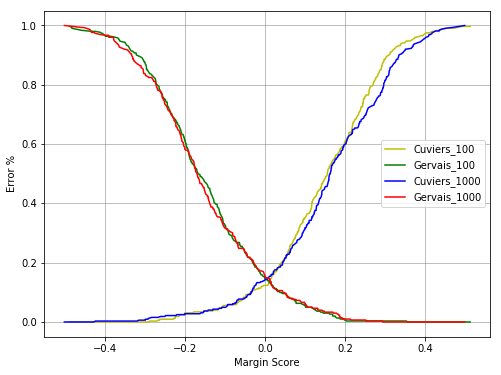

In [12]:
plt.figure(figsize=(8, 6))
legends = ['Cuviers_100', 'Gervais_100']
xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
legends = legends + ['Cuviers_1000', 'Gervais_1000']
xgbh.get_margin_plot(error_cuv_1000, error_ger_1000, thresholds_1000, legends = legends, style=['b', 'r'])

plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
thr = thresholds_100/(np.max(thresholds_100) - np.min(thresholds_100))
plt.show()

## Highlighting region of importance

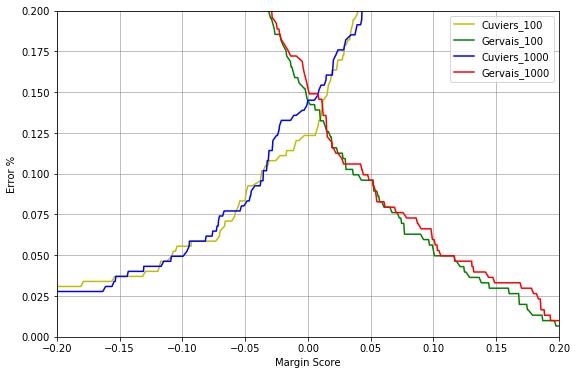

In [13]:
plt.figure(figsize=(9, 6))

legends = ['Cuviers_100', 'Gervais_100']
xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])

legends = legends + ['Cuviers_1000', 'Gervais_1000']
xgbh.get_margin_plot(error_cuv_1000, error_ger_1000, thresholds_1000, legends = legends, style=['b', 'r'])

plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

plt.xlim([-0.2, 0.2])
plt.ylim([0, 0.2])
plt.show()

## ROC Curve

Plotting the ROC curve using the true and predicted labels. The plots were done for 100 and 1000 iterations.

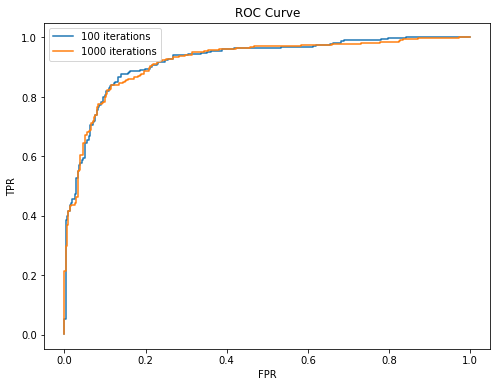

In [14]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_100)
plt.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_1000)
plt.plot(fpr, tpr)
plt.legend(['100 iterations','1000 iterations'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve")
plt.show()

# ROC Analysis

We concentrate on the region where true positive rate(TPR) starts becoming constant or before true positive rate(TPR) goes beyond 0.5. We analyze this region by abstaining small subsets of the remaining area. We experiment with different conditions for TPR and FPR in this region and we observe the accuracy and amount that has been abstained in each case. We identified that abstaining some part of the region in between gave us better accuracy. 

Thresholds (lower, upper): -0.14307801 0.17014246
Accuracy: 0.936416,
Cuvier Accuracy: 0.943396,
Gervais Accuracy: 0.930481,
Abstain: 0.447284


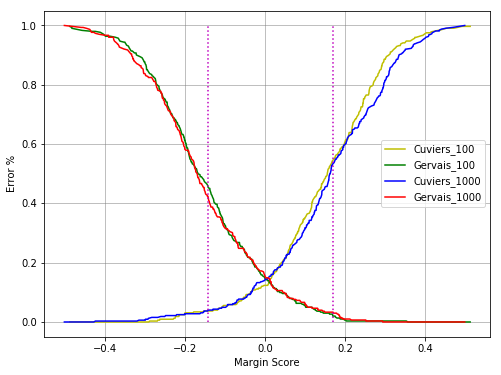

In [15]:
thr_lower_index = np.min(np.where((tpr > 0.95) & (fpr > 0.4)))
thr_upper_index = np.max(np.where((tpr < 0.5) & (fpr  < 0.05)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
#print("Thresholds (lower, upper):", thr_lower, thr_upper)

acc, cuvier_acc, gervais_acc, abstain = xgbh.statistics(y_pred_1000, y_test, thr_lower, thr_upper)

thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)

print("Accuracy: %f,\nCuvier Accuracy: %f,\nGervais Accuracy: %f,\nAbstain: %f" % (acc, cuvier_acc, gervais_acc, abstain))

plt.figure(figsize=(8, 6))
legends = ['Cuviers_100', 'Gervais_100']
xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
legends = legends + ['Cuviers_1000', 'Gervais_1000']
xgbh.get_margin_plot(error_cuv_1000, error_ger_1000, thresholds_1000, legends = legends, style=['b', 'r'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

Accuracy: 0.934783,
Cuvier Accuracy: 0.942408,
Gervais Accuracy: 0.928251,
Abstain: 0.338658
Thresholds (lower, upper): -0.09930418 0.14391711


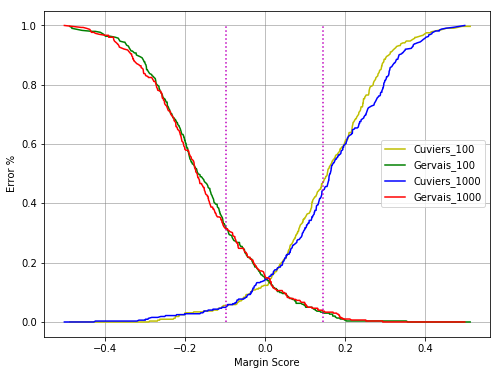

In [16]:
thr_lower_index = np.min(np.where((tpr > 0.95)))
thr_upper_index = np.max(np.where((tpr  < 0.6)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
#print("Thresholds (lower, upper):", thr_lower, thr_upper)
acc,cuvier_acc, gervais_acc, abstain = xgbh.statistics(y_pred_1000, y_test, thr_lower, thr_upper)
print("Accuracy: %f,\nCuvier Accuracy: %f,\nGervais Accuracy: %f,\nAbstain: %f" % (acc, cuvier_acc, gervais_acc, abstain))

thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)

plt.figure(figsize=(8, 6))
legends = ['Cuviers_100', 'Gervais_100']
xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
legends = legends + ['Cuviers_1000', 'Gervais_1000']
xgbh.get_margin_plot(error_cuv_1000, error_ger_1000, thresholds_1000, legends = legends, style=['b', 'r'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

Accuracy: 0.926136,
Cuvier Accuracy: 0.989796,
Gervais Accuracy: 0.901575,
Abstain: 0.437700
Thresholds (lower, upper): -0.053089887 0.25101793


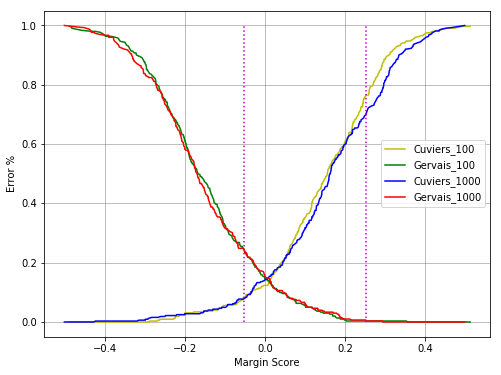

In [17]:
thr_lower_index = np.min(np.where((tpr > 0.92)))
thr_upper_index = np.max(np.where((tpr  < 0.3)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
#print("Thresholds (lower, upper):", thr_lower, thr_upper)
acc,cuvier_acc, gervais_acc, abstain = xgbh.statistics(y_pred_1000, y_test, thr_lower, thr_upper)
print("Accuracy: %f,\nCuvier Accuracy: %f,\nGervais Accuracy: %f,\nAbstain: %f" % (acc, cuvier_acc, gervais_acc, abstain))

thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)

plt.figure(figsize=(8, 6))
legends = ['Cuviers_100', 'Gervais_100']
xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
legends = legends + ['Cuviers_1000', 'Gervais_1000']
xgbh.get_margin_plot(error_cuv_1000, error_ger_1000, thresholds_1000, legends = legends, style=['b', 'r'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

# Bootstrap Analysis

In [18]:
data  = np.load("Data/processed_data_15mb.np")

In [19]:
def get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp, num_chunks=20):
    error_cuv_bin = np.array(np.array(error_cuv_samp) * num_chunks, dtype=int)
    error_cuv_bin[error_cuv_bin == num_chunks] = num_chunks - 1    #Classifying error=1.0 in the range 0.95-1.00
    error_ger_bin = np.array(np.array(error_ger_samp) * num_chunks, dtype=int)
    error_ger_bin[error_ger_bin == num_chunks] = num_chunks - 1    #Classifying error=1.0 in the range 0.95-1.00
    
    min_cuv = np.zeros(num_chunks, dtype=float)
    max_cuv = np.zeros(num_chunks, dtype=float)
    min_ger = np.zeros(num_chunks, dtype=float)
    max_ger = np.zeros(num_chunks, dtype=float)
    
    normalizing_factor = (max(thresholds_samp) - min(thresholds_samp))
    for i in range(num_chunks):
        min_cuv[i] = thresholds_samp[np.min(np.where(error_cuv_bin == i))]/normalizing_factor
        max_cuv[i] = thresholds_samp[np.max(np.where(error_cuv_bin == i))]/normalizing_factor
        min_ger[i] = thresholds_samp[np.min(np.where(error_ger_bin == i))]/normalizing_factor
        max_ger[i] = thresholds_samp[np.max(np.where(error_ger_bin == i))]/normalizing_factor
            
    return min_cuv, max_cuv, min_ger, max_ger

In [20]:
def generate_samples(data, bootstrap_size=500, num_chunks=20, show_bootstraps=True):
    for i in range(10):
        if i == 0:
            min_cuv = np.zeros(num_chunks, dtype=float)
            max_cuv = np.zeros(num_chunks, dtype=float)
            min_ger = np.zeros(num_chunks, dtype=float)
            max_ger = np.zeros(num_chunks, dtype=float)
        
        #Sampling Random indices for selection
        samp_indices = np.random.randint(len(data), size=bootstrap_size)
        
        #Test data and labels
        X_samp = data[samp_indices, :-1]
        y_samp = np.array(data[samp_indices, -1], dtype=int)
        
        #Test predictions
        dsamp = xgb.DMatrix(X_samp, label=y_samp)    
        y_samp_pred = bst.predict(dsamp, ntree_limit=bst.best_ntree_limit, output_margin=True)

        ## For 100 iterations
        thresholds_samp = sorted(np.unique(np.round(y_samp_pred, 2)))
        error_cuv_samp, error_ger_samp = xgbh.get_error_values(y_samp_pred, y_samp, thresholds_samp)
        
        min_cuv_samp, max_cuv_samp, min_ger_samp, max_ger_samp = get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp, num_chunks)
        if i == 0:
            min_cuv = min_cuv_samp
            max_cuv = max_cuv_samp
            min_ger = min_ger_samp
            max_ger = max_ger_samp
        else:
            min_cuv[min_cuv > min_cuv_samp] = min_cuv_samp[min_cuv > min_cuv_samp]
            max_cuv[max_cuv < max_cuv_samp] = max_cuv_samp[max_cuv < max_cuv_samp]
            min_ger[min_ger > min_ger_samp] = min_ger_samp[min_ger > min_ger_samp]
            max_ger[max_ger < max_ger_samp] = max_ger_samp[max_ger < max_ger_samp]    
        
        if show_bootstraps:
            xgbh.get_margin_plot(error_cuv_samp, error_ger_samp, thresholds_samp, legends = legends, style=['g', 'y'])
    
    for i in range(num_chunks):
        plt.plot([min_cuv[i], max_cuv[i]], [(1.0*i)/num_chunks, (1.0*i)/num_chunks], 'b')
        plt.plot([min_ger[i], max_ger[i]], [(1.0*i)/num_chunks, (1.0*i)/num_chunks], 'r')
    

Thresholds (lower, upper): -0.09930418 0.14391711


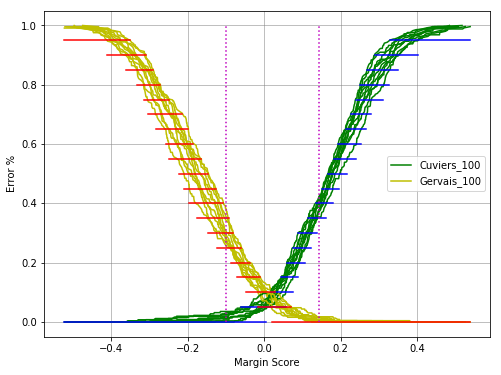

In [21]:
plt.figure(figsize=(8, 6))
#legends = ['Cuviers', 'Gervais']


#Best thresholds from the ROC Analysis
thr_lower_index = np.min(np.where((tpr > 0.95)))
thr_upper_index = np.max(np.where((tpr  < 0.6)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)


generate_samples(data, num_chunks=20, show_bootstraps=True)



#xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.xlabel('Margin Score')
plt.ylabel('Error %')
legends = ['Cuviers_100', 'Gervais_100']
plt.legend(legends)
plt.show()

Thresholds (lower, upper): -0.09930418 0.14391711


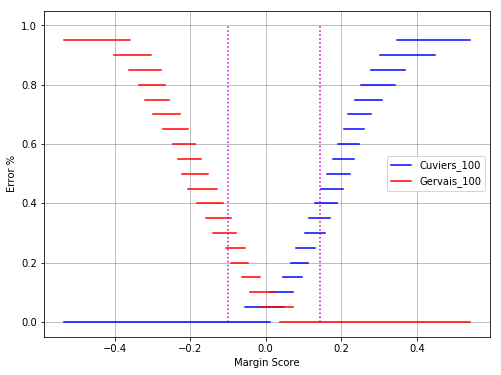

In [22]:
plt.figure(figsize=(8, 6))
#legends = ['Cuviers', 'Gervais']


#Best thresholds from the ROC Analysis
thr_lower_index = np.min(np.where((tpr > 0.95)))
thr_upper_index = np.max(np.where((tpr  < 0.6)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)


generate_samples(data, num_chunks=20, show_bootstraps=False)

plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.xlabel('Margin Score')
plt.ylabel('Error %')
legends = ['Cuviers_100', 'Gervais_100']
plt.legend(legends)
plt.show()